In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from insightface.app import FaceAnalysis
from sklearn.metrics import pairwise
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

C:\Users\tanya\OneDrive\Desktop\Face Recognition Attendance System - Copy - Copy\Attendance_System\Notes\attendance_system\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [43]:
# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------

model_name_dy = "antelopev2"
test_folder = 'lfw_test'  # ← path to your custom dataset
reference_embeddings_path = "combined_embeddings_{}.pkl".format(model_name_dy)
save_results_folder = "saved_results_lfw_fixed__thresh"  # ← do NOT overwrite LFW results!


In [44]:
# -----------------------------------------------------------------------------
# 1) Prepare FaceAnalysis model
# -----------------------------------------------------------------------------

faceapp = FaceAnalysis(name=model_name_dy, root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\antelopev2\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\antelopev2\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\antelopev2\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\antelopev2\glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\antelopev2\scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


In [45]:
# -----------------------------------------------------------------------------
# 2) Helper Functions
# -----------------------------------------------------------------------------

def clean_name(string):
    return re.sub(r'[^A-Za-z]', ' ', string).title()

def find_best_threshold(y_true, y_score):
    best_thr, best_f1 = 0.0, 0.0
    for thr in np.linspace(0.0, 1.0, 101):
        y_pred_temp = (y_score >= thr).astype(int)
        f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
        if f1_temp > best_f1:
            best_f1, best_thr = f1_temp, thr
    return best_thr, best_f1

def save_model_results(model_name, y_true, y_pred, y_score, threshold, save_path):
    os.makedirs(save_path, exist_ok=True)
    results = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_score': y_score,
        'threshold': threshold
    }
    with open(os.path.join(save_path, f"{model_name}.pkl"), 'wb') as f:
        pickle.dump(results, f)

def load_all_model_results(save_path):
    all_results = {}
    for file in os.listdir(save_path):
        if file.endswith('.pkl'):
            model = file.replace('.pkl', '')
            with open(os.path.join(save_path, file), 'rb') as f:
                all_results[model] = pickle.load(f)
    return all_results


In [46]:
# -----------------------------------------------------------------------------
# 3) Load Combined Reference Embeddings
# -----------------------------------------------------------------------------
print(reference_embeddings_path)
if not os.path.exists(reference_embeddings_path):
    raise FileNotFoundError(f"❌ Missing reference embeddings: {reference_embeddings_path}")

dataframe = pd.read_pickle(reference_embeddings_path)
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)
print(f"✅ Reference embeddings loaded: {dataframe.shape}")

combined_embeddings_antelopev2.pkl
✅ Reference embeddings loaded: (2402, 3)


In [47]:
# -----------------------------------------------------------------------------
# 4) Evaluate on Custom Test Folder
# -----------------------------------------------------------------------------

total_images = 0

# For final metrics:
y_true = []   # 1 if correct match, 0 if incorrect
y_score = []  # confidence scores (cosine similarity)

for person_folder in os.listdir(test_folder):
    person_path = os.path.join(test_folder, person_folder)

    # If it's not a directory, skip
    if not os.path.isdir(person_path):
        continue

    # Clean up folder name (remove teacher/student)
    actual_name_cleaned = person_folder.lower()
    actual_name_cleaned = actual_name_cleaned.replace("student-", "")
    actual_name_cleaned = actual_name_cleaned.replace("teacher-", "")
    actual_name_cleaned = actual_name_cleaned.replace("_", " ")

    # Process images within that folder
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)
        img_test = cv2.imread(image_path)

        if img_test is None:
            print(f"Skipping {image_path} (invalid image)")
            continue

        total_images += 1

        # Detect face(s) in the test image
        res_test = faceapp.get(img_test, max_num=0)
        if not res_test:
            print(f"No face detected in {image_name}")
            continue

        # We'll assume first face is the main face
        embed_test = res_test[0]['embedding'].reshape(1, -1)

        # Compute similarity to all reference embeddings
        cosine_similar = pairwise.cosine_similarity(X, embed_test).flatten()

        # Find best match
        best_match_index = np.argmax(cosine_similar)
        predicted_name = dataframe.loc[best_match_index]['Name'].lower()

        # Evaluate correctness: check if predicted is in "actual_name_cleaned"
        if predicted_name in actual_name_cleaned:
            y_true.append(1)
        else:
            y_true.append(0)

        # Save best-match score
        best_match_score = cosine_similar[best_match_index]
        y_score.append(best_match_score)

        print(f"Image: {image_name} → Predicted: {predicted_name}, "
              f"Actual: {actual_name_cleaned}, Score: {best_match_score:.4f}")


Image: Aaron_Peirsol_0003.jpg → Predicted: aaron peirsol, Actual: aaron peirsol, Score: 0.7717
Image: Abdoulaye_Wade_0004.jpg → Predicted: abdoulaye wade, Actual: abdoulaye wade, Score: 0.7252
Image: Abdullah_0003.jpg → Predicted: abdullah, Actual: abdullah, Score: 0.7318
Image: Abdullah_Gul_0002.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.9169
Image: Abdullah_Gul_0003.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7765
Image: Abdullah_Gul_0005.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7648
Image: Abdullah_Gul_0006.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.8086
Image: Abdullah_Gul_0007.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.8204
Image: Abdullah_Gul_0008.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.8403
Image: Abdullah_Gul_0009.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7962
Image: Abdullah_Gul_0010.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score

In [55]:
# -----------------------------------------------------------------------------
# 5) Threshold Selection and Save Results
# -----------------------------------------------------------------------------
# threshold_for_classification, _ = find_best_threshold(np.array(y_true), np.array(y_score))
# y_pred = (np.array(y_score) >= threshold_for_classification).astype(int)

threshold_for_classification = 0.5
y_score = np.array(y_score)
y_pred = (y_score >= threshold_for_classification).astype(int)

save_model_results(model_name_dy, y_true, y_pred, y_score, threshold_for_classification, save_results_folder)
print(f"\n✅ Model results saved to {save_results_folder}/{model_name_dy}.pkl")


✅ Model results saved to saved_results_lfw_fixed__thresh/antelopev2.pkl


In [56]:
results_metric_dy = load_all_model_results(save_results_folder)
results_metric_dy

{'antelopev2': {'y_true': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1

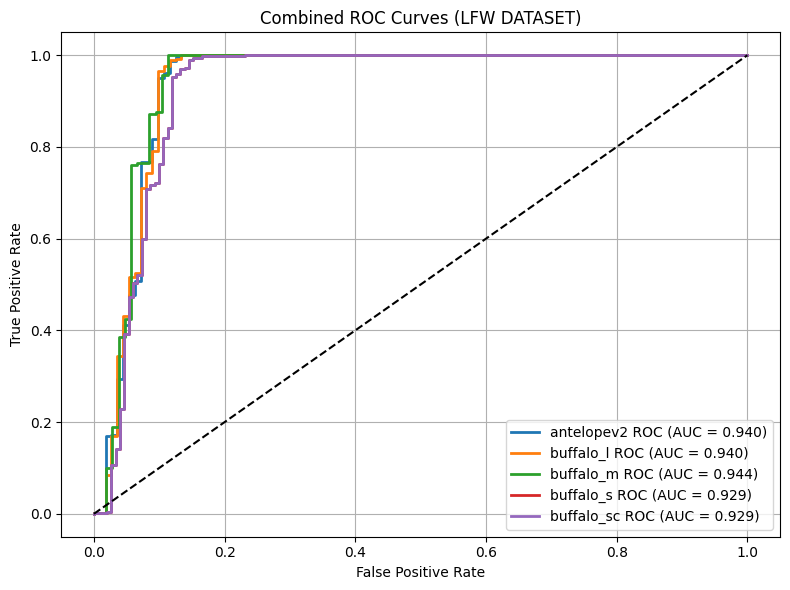

In [57]:
# -----------------------------------------------------------------------------
# 6) Plot ROC + Confusion Matrix + Report (All Models in saved_results_custom)
# -----------------------------------------------------------------------------

# Plot ROC
plt.figure(figsize=(8, 6))

for model, data in results_metric_dy.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['y_score'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model} ROC (AUC = {roc_auc:.3f})", linewidth=2)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Combined ROC Curves (LFW DATASET)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_results_folder, "combined_roc_curve_custom.png"), dpi=300)
plt.show()


📊 Confusion Matrix for Model: antelopev2


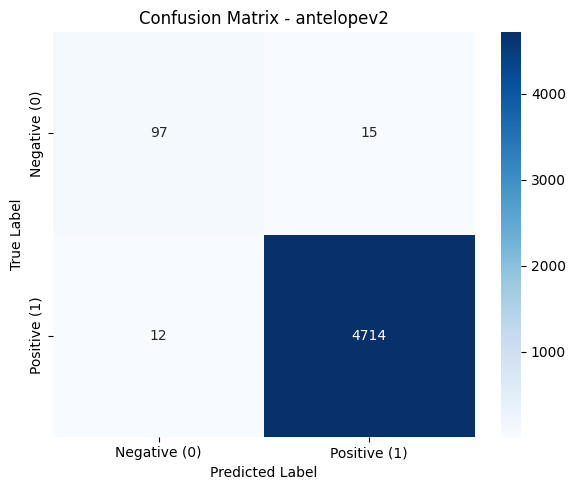

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.890     0.866     0.878       112
           1      0.997     0.997     0.997      4726

    accuracy                          0.994      4838
   macro avg      0.943     0.932     0.937      4838
weighted avg      0.994     0.994     0.994      4838


📊 Confusion Matrix for Model: buffalo_l


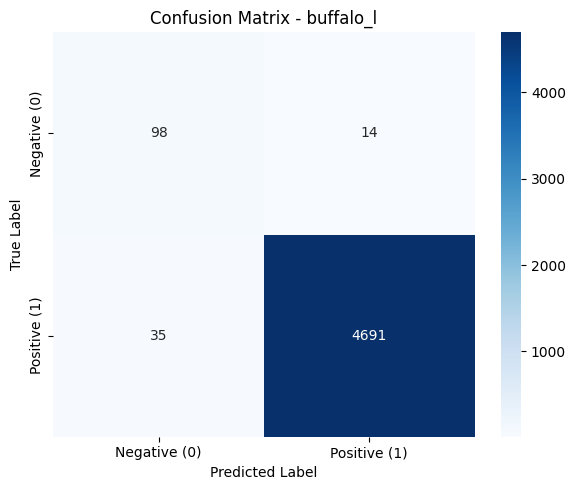

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.737     0.875     0.800       112
           1      0.997     0.993     0.995      4726

    accuracy                          0.990      4838
   macro avg      0.867     0.934     0.897      4838
weighted avg      0.991     0.990     0.990      4838


📊 Confusion Matrix for Model: buffalo_m


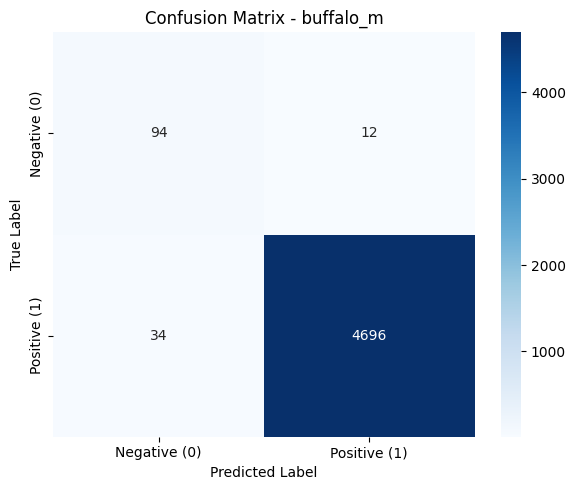

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.734     0.887     0.803       106
           1      0.997     0.993     0.995      4730

    accuracy                          0.990      4836
   macro avg      0.866     0.940     0.899      4836
weighted avg      0.992     0.990     0.991      4836


📊 Confusion Matrix for Model: buffalo_s


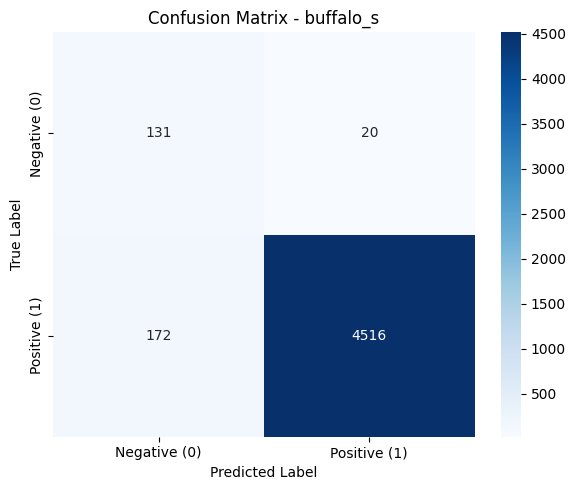

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.432     0.868     0.577       151
           1      0.996     0.963     0.979      4688

    accuracy                          0.960      4839
   macro avg      0.714     0.915     0.778      4839
weighted avg      0.978     0.960     0.967      4839


📊 Confusion Matrix for Model: buffalo_sc


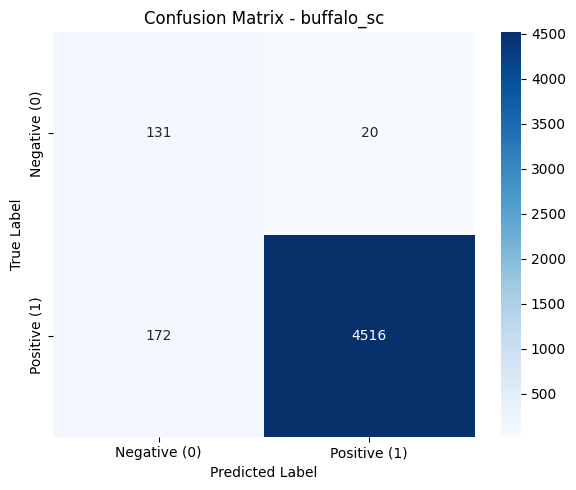

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.432     0.868     0.577       151
           1      0.996     0.963     0.979      4688

    accuracy                          0.960      4839
   macro avg      0.714     0.915     0.778      4839
weighted avg      0.978     0.960     0.967      4839



In [58]:

# Plot Confusion Matrix and Report
for model, data in results_metric_dy.items():
    print(f"\n📊 Confusion Matrix for Model: {model}")
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    labels = ['Negative (0)', 'Positive (1)']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(os.path.join(save_results_folder, f"confusion_matrix_{model}.png"), dpi=300)
    plt.show()

    print("📄 Classification Report:")
    print(classification_report(data['y_true'], data['y_pred'], digits=3, zero_division=0))
